<a href="https://colab.research.google.com/github/cbevis/2015lab1/blob/master/Capstone_Neural_Net_Copy5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 311 Neural Networks 

Rev5 Notes:
Fit generator

Rev4 Notes:
Implementing a trained model
-VGG16
- Use 60000 datapoints for memory, 

Rev3 Notes:
- Added more layers to CNN, additional dropout
- Increased batch size
- Current accuracy at 51%


Rev2 Notes: 
 - Removed MLP on images - CNN is the way to go
 - Added layer on combined and changed filter size to 64

### References:
- Convert to grayscale: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744
- Keras early stopping: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
- Grayscale Keras: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
- Combining models: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
- Neighborhoods geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Plotting in folium: https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db2
- Using a pretrained network: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
import glob
from numpy import random
from PIL import Image

# Import Components for model building
# Import various components for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate, Input
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

# Import the backend
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

% matplotlib inline

Using TensorFlow backend.


In [4]:
# Check for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

!ls "/content/drive/My Drive/Colab Notebooks"

 311-Capstone-Neural-Net-Copy1.ipynb   bw_pickles
 311-Capstone-Neural-Net-Copy2.ipynb   Capstone-Neural-Net-Copy5.ipynb
 311-Capstone-Neural-Net-Copy3.ipynb  'Copy of Capstone-Neural-Net-Copy5.ipynb'
 311-Capstone-Neural-Net-Copy4.ipynb   Untitled0.ipynb


In [7]:
# Using the first 60000 data points
# Limited due to computational time and disc space
data_path = '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_[0-9]*.gzde'
files = glob.glob(data_path)
print(files)
dim1, dim2, dim3 = 128, 128, 1

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

# Drop files without an image
df.dropna(subset=['image'], inplace=True)
df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['month'] = df['month'].astype('int16')
df['year'] = df['year'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['police_district'] = df['police_district'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['status'] = df['status'].astype('category')
df['responsible_agency'] = df['responsible_agency'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')  

['/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_19000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_26000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_36000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_2000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_44000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_54000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_107000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_117000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_62000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_72000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_10000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_86000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_96000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_73000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pi

In [0]:
# Clear up some memory, don't end up using these columns
drop_cols = ['closed', 'updated', 'status', 'status_notes', 'image', 
             'address', 'supervisor_district', 'latitude', 'longitude', 'point', 
             'source', 'media_url', 'year', 'responsible_agency',
             'request_details']

In [0]:
df.sort_index(inplace=True)
X_flat = np.concatenate(df.image.values.tolist(), axis=0)
X_flat = X_flat.reshape(df.shape[0], dim1*dim2*dim3) 
df.drop(columns=drop_cols, inplace=True)


In [10]:
# Check the shape
X_flat.shape

(119266, 16384)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119266 entries, 0 to 119999
Data columns (total 8 columns):
caseid             119266 non-null int64
opened             119266 non-null datetime64[ns]
category           119266 non-null category
request_type       119266 non-null object
street             119266 non-null object
neighborhood       119266 non-null object
police_district    118996 non-null category
month              119266 non-null int16
dtypes: category(2), datetime64[ns](1), int16(1), int64(1), object(3)
memory usage: 5.9+ MB


In [12]:
df.head(2)

,caseid,opened,category,request_type,street,neighborhood,police_district,month
0,7228536,2017-06-06 07:31:38,Graffiti,Graffiti on Signal_box,6TH ST,South of Market,SOUTHERN,6
1,9848318,2018-11-25 13:15:00,Parking Enforcement,Other_Illegal_Parking,TAYLOR ST,Tenderloin,TENDERLOIN,11


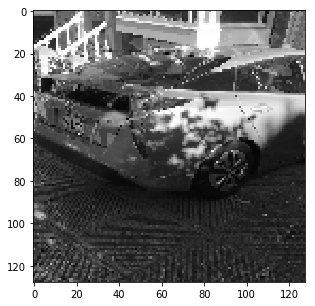

In [13]:
plt.figure(figsize=(5, 5))
plt.imshow(X_flat[5].reshape(128, 128), cmap='gray')
plt.show()

In [14]:
X_flat[0].shape

(16384,)

In [0]:
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [16]:
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Graffiti' 'Vehicle' 'General Cleaning' 'Litter Receptacles'
 'Hazardous Materials' 'Street and Sidewalk Issues'
 'Rec and Park Requests' 'Bulky Items' 'Encampments'
 'Human or Medical Waste' 'Other' 'Signs - Illegal Postings and Repair'
 'Tree Maintenance' 'Sewer Issues' 'Streetlights' 'Damaged Property']
16


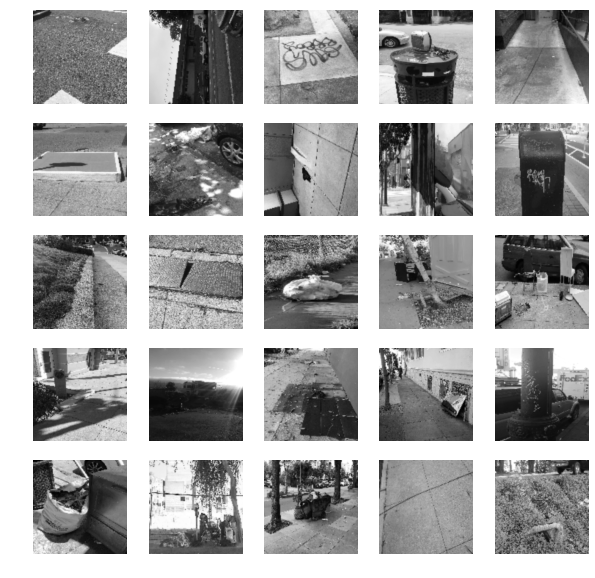

In [15]:
#Visualizing dataset
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_flat)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_flat[i:i+1][0].reshape(128, 128),
                           cmap='gray',
                           interpolation='gaussian')        

# Variables

In [25]:
rand_state = 38
features = ['month', 'neighborhood', 'street']
dim1, dim2, dim3 = 128, 128, 3
input_shape = (dim1, dim2, dim3)
# Need to use 3 channels if using vgg
num_classes = 16

# Label encode labels
X_train, X_test, y_train, y_test = train_test_split(X_flat, 
                                                    df['group'], 
                                                    test_size=0.25,
                                                    random_state=rand_state)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train = keras.utils.to_categorical(y_train_enc, 16)
y_test = keras.utils.to_categorical(y_test_enc, 16)

# We take care of X_train in the generator
#X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
#X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)
# Convert to float32 for type consistency
#X_test = X_test.astype('float32')
# Normalize values to 1 from 0 to 255 (256 values of pixels)
#X_test /= 255
#X_test = X_test.reshape(X_test.shape[0], dim1, dim2, dim3)


print(X_test.shape[0], 'test samples')

# Select features and one hot encode
X_cat = df[features]
ohe = OneHotEncoder()
X_cat = ohe.fit_transform(X_cat)
print('Categorical Variable:')
print('X one hot encoded: {}'.format(X_cat.shape))

# Use same y as before, same random_state
X_cat_train, X_cat_test = train_test_split(X_cat, 
                                           test_size=0.25,
                                           random_state=rand_state)

# Select features with variance threshold of 99.95%
# 1 or 0 in more than 99.95% of samples
sel = VarianceThreshold(threshold=(.9995*(1-.9995)))
X_sel_train = sel.fit_transform(X_cat_train)
X_sel_test = sel.transform(X_cat_test)
print('X_train Variance Threshold: {}'.format(X_sel_train.shape))

# Select K Best Features - didn't help
# k_num = X_sel_train.shape[1]
# sel_k = SelectKBest(chi2, k=k_num)
# X_sel_k = sel_k.fit_transform(X_sel_train, y_train)
# X_sel_k_test = sel_k.transform(X_sel_test)
# print('X_train Select K Best, K={}: {}'.format(k_num, X_sel_k.shape))


29817 test samples
Categorical Variable:
X one hot encoded: (119266, 2068)
X_train Variance Threshold: (89449, 457)


# Convolutional Neural Network
- Black and White 128x128 images

Following line is the memory hog.

In [21]:
y_test.shape

(29817, 16)

Model performs much worse if filters set to 64, 128, 256

In [0]:
# This returns a tensor
inputs = Input(shape=input_shape)
chan_dim = -1

# Add VCG layer on top

x1 = Conv2D(32, (3, 3), padding='same')(inputs)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(32, (3, 3), padding='same')(inputs)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)
x1 = Dense(num_classes)(x1)
x1 = Activation('softmax')(x1)

cnn = Model(inputs, x1)

In [0]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_cnn.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]


# fits the model on batches with real-time data augmentation:
cnn.fit_generator(generator(X_train, y_train, 256), 
                  steps_per_epoch=351,
                  verbose=1,
                  epochs=50,
                  validation_data=val_generator(X_test, y_test, 32),
                  validation_steps=X_test.shape[0]/32)


#history = cnn.fit(X_train, y_train,
#                  batch_size=128,
#                  epochs=25,
#                  verbose=1,
#                  callbacks=callbacks,
#                  validation_data=(X_test, y_test))
score = cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
351/351 [==============================] - 92s 262ms/step - loss: 2.6259 - acc: 0.1718 - val_loss: 2.3558 - val_acc: 0.1903
Epoch 2/50
351/351 [==============================] - 87s 249ms/step - loss: 2.4565 - acc: 0.1822 - val_loss: 2.3541 - val_acc: 0.1903
Epoch 3/50
 10/351 [..............................] - ETA: 1:14 - loss: 2.4884 - acc: 0.1805

In [0]:
y_pred = cnn.predict(X_test)
print(y_pred.shape)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_conf = np.argmax(y_test_g, axis=1)
confusion_matrix = confusion_matrix(y_true=y_test_conf, y_pred=y_pred_labels)

In [0]:
print(le_group.inverse_transform(range(0, 16)))
print(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))
print('classified as:')
print(le_group.inverse_transform([0, 2, 3, 4, 9, 12]))

['Bulky Items' 'Damaged Property' 'Encampments' 'General Cleaning'
 'Graffiti' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Rec and Park Requests' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Street and Sidewalk Issues'
 'Streetlights' 'Tree Maintenance' 'Vehicle']
['Damaged Property' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Streetlights' 'Tree Maintenance'
 'Vehicle']
classified as:
['Bulky Items' 'Encampments' 'General Cleaning' 'Graffiti'
 'Rec and Park Requests' 'Street and Sidewalk Issues']


No predictions for the following: 'Damaged Property' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Streetlights' 'Tree Maintenance'
 'Vehicle']

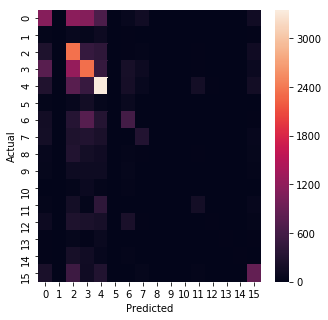

In [0]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# VGG

In [18]:
vgg_conv = VGG16(weights='imagenet', include_top=False)


# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

    # This returns a tensor
inputs = Input(shape=input_shape)
chan_dim = -1

# Add VCG layer on top
x2 = vgg_conv(inputs)

x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
x2 = Dense(num_classes)(x2)
x2 = Activation('softmax')(x2)

vgg = Model(inputs, x2)



Instructions for updating:
Colocations handled automatically by placer.
<keras.engine.input_layer.InputLayer object at 0x7fcc94c25f60> False
<keras.layers.convolutional.Conv2D object at 0x7fcc9599a048> False
<keras.layers.convolutional.Conv2D object at 0x7fcc95f46b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc93be2c50> False
<keras.layers.convolutional.Conv2D object at 0x7fccb1c04668> False
<keras.layers.convolutional.Conv2D object at 0x7fccb60ceef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fccb65711d0> False
<keras.layers.convolutional.Conv2D object at 0x7fccb03ba588> False
<keras.layers.convolutional.Conv2D object at 0x7fcc94df5550> False
<keras.layers.convolutional.Conv2D object at 0x7fcc94cc5908> False
<keras.layers.pooling.MaxPooling2D object at 0x7fccb04210f0> False
<keras.layers.convolutional.Conv2D object at 0x7fccb0421518> False
<keras.layers.convolutional.Conv2D object at 0x7fccb195a208> False
<keras.layers.convolutional.Conv2D object at 0x7fcc941d

In [26]:
# https://github.com/spmallick/learnopencv/blob/master/Keras-Fine-Tuning/keras-finetune-vgg.ipynb
# https://medium.com/@fromtheast/implement-fit-generator-in-keras-61aa2786ce98
# https://stackoverflow.com/questions/46493419/use-a-generator-for-keras-model-fit-generator
# Data generator for training data
def generator(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
  batch_features = np.zeros((batch_size, 128, 128, 3))
  batch_labels = np.zeros((batch_size, 16))
  while True:
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(len(features),1)
      sample = features[index]
      sample = sample.reshape(128, 128)
      sample = np.repeat(sample[..., np.newaxis], 3, -1)
      #print(features[index].shape)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
      
    batch_features = batch_features.astype('float32')
    batch_features /=255
    print(batch_features[0])
    print(batch_labels[0])
    yield batch_features, batch_labels
    
def val_generator(features, labels, batch_size):

  samples_per_epoch = features.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter = 0

  while True:

    batch_features = np.array(features[batch_size*counter:min(batch_size*(counter+1), features.shape[0])]).astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128)
    batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features /=255
    
    batch_labels = np.array(labels[batch_size*counter:min(batch_size*(counter+1), features.shape[0])])
    counter += 1
    yield batch_features, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0
  
    
    
vgg.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_cnn.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]


# fits the model on batches with real-time data augmentation:
vgg.fit_generator(generator(X_train, y_train, 256), 
                  steps_per_epoch=351,
                  verbose=1,
                  epochs=50,
                  validation_data=val_generator(X_test, y_test, 32),
                  validation_steps=X_test.shape[0]/32)


#score = vgg.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

Epoch 1/50
351/351 [==============================] - 203s 578ms/step - loss: 14.0418 - acc: 0.1242 - val_loss: 13.8828 - val_acc: 0.1206
Epoch 2/50
351/351 [==============================] - 201s 574ms/step - loss: 14.0074 - acc: 0.1263 - val_loss: 13.9823 - val_acc: 0.1203
Epoch 3/50
351/351 [==============================] - 201s 573ms/step - loss: 14.0858 - acc: 0.1222 - val_loss: 13.9875 - val_acc: 0.1207
Epoch 4/50
351/351 [==============================] - 201s 573ms/step - loss: 14.0653 - acc: 0.1231 - val_loss: 13.9795 - val_acc: 0.1202
Epoch 5/50
351/351 [==============================] - 201s 573ms/step - loss: 14.0458 - acc: 0.1240 - val_loss: 13.9749 - val_acc: 0.1202
Epoch 6/50
351/351 [==============================] - 201s 574ms/step - loss: 14.0263 - acc: 0.1255 - val_loss: 14.0091 - val_acc: 0.1201
Epoch 7/50
 79/351 [=====>........................] - ETA: 1:58 - loss: 14.0206 - acc: 0.1256

KeyboardInterrupt: ignored

In [36]:
np.repeat(X_train[0].reshape(128, 128)[..., np.newaxis], 3, -1).shape

(128, 128, 3)

# Model for Categorical Variables - Multi Layer Perceptron (MLP)

In [0]:
input_shape_cat = X_sel_train.shape[1]

# This returns a tensor
inputs = Input(shape=(input_shape_cat,))

# a layer instance is callable on a tensor and returns a tensor
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(16, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
mlp = Model(inputs=inputs, outputs=predictions)

"\nmlp.compile(loss='categorical_crossentropy',\n            optimizer='rmsprop',\n            metrics=['accuracy'])\n\ncallbacks = [EarlyStopping(monitor='val_loss', patience=2),\n             ModelCheckpoint(filepath='best_model_cat.h5', \n                             monitor='val_loss', \n                             save_best_only=True)]\n\nhistory = mlp.fit(X_sel_k, y_train_g,\n                  batch_size=128,\n                  epochs=20,\n                  verbose=1,\n                  callbacks=callbacks,\n                  validation_data=(X_sel_k_test, y_test_g))\nscore = mlp.evaluate(X_sel_k_test, y_test_g, verbose=0)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])\n"

In [0]:
mlp.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_cat.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = mlp.fit(X_sel_train, y_train,
                  batch_size=128,
                  epochs=20,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=(X_sel_test, y_test))
score = mlp.evaluate(X_sel_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Combine Models

In [0]:
# combine the output of previous two models
combined_input = concatenate([vgg.output])

# Final Fully Connected layer head, 2 dense layers
#x3 = Dense(32, activation='relu')(combined_input)
#x3 = Dropout(0.5)(x3)
#x3 = Dense(64, activation='relu')(x3)
#x3 = Dropout(0.5)(x3)
#x3 = Dense(16, activation='softmax')(x3)
                              
# Final model accepts input from both mlp and cnn
model = Model(inputs=[vgg.input], outputs=x3)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

def generator(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
  batch_features = np.zeros((batch_size, 128, 128, 3))
  batch_labels = np.zeros((batch_size,1))
  
  while True:
    for i in range(batch_size):
      # choose random index in features
      index= random.choice(len(features),1)
      batch_features[i] = features[index]
      
    batch_features =  np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.astype('float32')
    batch_features /= 255  
    batch_features.reshape(batch_features.shape[0], dim1, dim2, dim3)
      
    yield batch_features, batch_labels


callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_all.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit_generator([X_train, X_train], y_train,
                     batch_size=32,
                     epochs=20,
                     verbose=1,
                     callbacks=callbacks,
                     validation_data=([X_sel_test, X_test, X_test], y_test))
score = model.evaluate([X_sel_test, X_test, X_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 56250 samples, validate on 18750 samples
Epoch 1/20
56250/56250 [==============================] - 237s 4ms/step - loss: 2.2591 - acc: 0.2360 - val_loss: 2.1362 - val_acc: 0.2844
Epoch 2/20
56250/56250 [==============================] - 227s 4ms/step - loss: 2.1215 - acc: 0.3057 - val_loss: 2.1389 - val_acc: 0.3014
Epoch 3/20
56250/56250 [==============================] - 227s 4ms/step - loss: 2.0596 - acc: 0.3362 - val_loss: 2.3365 - val_acc: 0.2445
Epoch 4/20
56250/56250 [==============================] - 228s 4ms/step - loss: 2.0281 - acc: 0.3513 - val_loss: 2.0977 - val_acc: 0.3202
Epoch 5/20
56250/56250 [==============================] - 227s 4ms/step - loss: 2.0061 - acc: 0.3599 - val_loss: 2.0062 - val_acc: 0.3465
Epoch 6/20
56250/56250 [==============================] - 228s 4ms/step - loss: 1.9904 - acc: 0.3677 - val_loss: 1.9666 - val_acc: 0.3663
Epoch 7/20
56250/56250 [==============================] - 227s 4ms/step - 

In [0]:
from google.colab import files
files.download('best_model_all.h5')

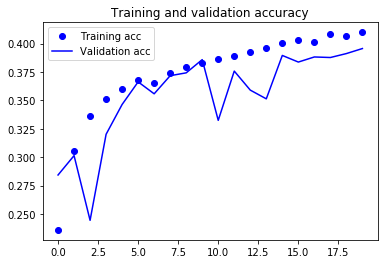

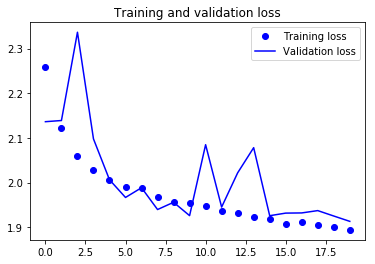

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ROC Curves
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
Micro Average vs Macro Average: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. 

In [0]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_g[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# Plot all ROC curves
plt.figure()
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()